In [2]:
import ee
import pandas as pd
import geopandas as gpd
import time
import os
from datetime import datetime
from shapely.geometry import mapping
import numpy as np

In [4]:
# 读取用户提供的州级 yield 数据（已排序）
state_yield_df = pd.read_csv("../data/Sorted_State-Year_Data.csv")

# 标准化列名
state_yield_df.columns = state_yield_df.columns.str.lower()

# 检查每个州的缺失年份情况
all_years = set(range(2000, 2025))
state_missing_years = state_yield_df.groupby("state")["year"].apply(lambda x: sorted(all_years - set(x)))

# 统计缺失年份数量
state_missing_summary = state_missing_years.apply(len).reset_index(name="missing_years_count")
state_missing_summary["missing_years"] = state_missing_years.values

print(state_missing_summary)

             state  missing_years_count                         missing_years
0          ALABAMA                    0                                    []
1          ARIZONA                    0                                    []
2         ARKANSAS                    0                                    []
3       CALIFORNIA                    0                                    []
4         COLORADO                    0                                    []
5         DELAWARE                    0                                    []
6          FLORIDA                    6  [2019, 2020, 2021, 2022, 2023, 2024]
7          GEORGIA                    0                                    []
8            IDAHO                    0                                    []
9         ILLINOIS                    0                                    []
10         INDIANA                    0                                    []
11            IOWA                    6  [2019, 2020, 2021, 2022

springdata

In [ ]:
import pandas as pd

# 1. 读取原始数据
df = pd.read_csv("../data/spring_wheat_yield_filtered.csv")
df.columns = df.columns.str.lower()
df = df[["state", "year", "yield_bu_acre"]]  # 只保留必要列

# 2. 构建完整 state-year 
all_states = df["state"].unique()
all_years = list(range(2000, 2025))
full_index = pd.MultiIndex.from_product([all_states, all_years], names=["state", "year"])
df_full = pd.DataFrame(index=full_index).reset_index()

# 3. 合并已有 yield 数据
df_merged = pd.merge(df_full, df, on=["state", "year"], how="left")

# 4. 计算缺失年份数量并移除缺失超过16年的州
state_missing = df_merged.groupby("state")["yield_bu_acre"].apply(lambda x: x.isna().sum())
valid_states = state_missing[state_missing <= 16].index
df_filtered = df_merged[df_merged["state"].isin(valid_states)].copy()

# 5. 线性插值
df_filtered["yield_bu_acre"] = df_filtered.groupby("state")["yield_bu_acre"].transform(
    lambda x: x.interpolate(limit_direction="both")
)

# 6. 用州均值填补仍缺失值
df_filtered["yield_bu_acre"] = df_filtered.groupby("state")["yield_bu_acre"].transform(
    lambda x: x.fillna(x.mean())
)

# 7. 最终检查
missing_final = df_filtered["yield_bu_acre"].isna().sum()
assert missing_final == 0, f"There are still {missing_final} missing values."

# 8. 输出填补后的文件
df_filtered.to_csv("../data/spring_yield_filled_2000_2024.csv", index=False)
print(" Saved spring_yield_filled_2000_2024.csv")


 Saved spring_yield_filled_2000_2024.csv


winterdata

In [36]:
import pandas as pd

# 1. 读取原始数据
df = pd.read_csv("../data/winter_wheat_yield_filtered.csv")
df.columns = df.columns.str.lower()
df = df[["state", "year", "yield_bu_acre"]]  # 只保留必要列

# 2. 构建完整 state-year 
all_states = df["state"].unique()
all_years = list(range(2000, 2025))
full_index = pd.MultiIndex.from_product([all_states, all_years], names=["state", "year"])
df_full = pd.DataFrame(index=full_index).reset_index()

# 3. 合并已有 yield 数据
df_merged = pd.merge(df_full, df, on=["state", "year"], how="left")

# 4. 计算缺失年份数量并移除缺失超过16年的州
state_missing = df_merged.groupby("state")["yield_bu_acre"].apply(lambda x: x.isna().sum())
valid_states = state_missing[state_missing <= 15].index
df_filtered = df_merged[df_merged["state"].isin(valid_states)].copy()

# 5. 线性插值
df_filtered["yield_bu_acre"] = df_filtered.groupby("state")["yield_bu_acre"].transform(
    lambda x: x.interpolate(limit_direction="both")
)

# 6. 用州均值填补仍缺失值
df_filtered["yield_bu_acre"] = df_filtered.groupby("state")["yield_bu_acre"].transform(
    lambda x: x.fillna(x.mean())
)

# 7. 最终检查
missing_final = df_filtered["yield_bu_acre"].isna().sum()
assert missing_final == 0, f"There are still {missing_final} missing values."

# 8. 输出填补后的文件
df_filtered.to_csv("../data/winter_yield_filled_2000_2024.csv", index=False)
print(" Saved winter_yield_filled_2000_2024.csv")


 Saved winter_yield_filled_2000_2024.csv


In [5]:


# 假设你已经读取数据
df = pd.read_csv("../data/Sorted_State-Year_Data.csv")
df.columns = df.columns.str.lower()

# 构建完整州-年组合（2000–2024）
all_years = list(range(2000, 2025))
all_states = df['state'].unique()
full_index = pd.MultiIndex.from_product([all_states, all_years], names=['state', 'year'])
df_full = pd.DataFrame(index=full_index).reset_index()

# 合并已有 yield 数据
df = pd.merge(df_full, df, on=['state', 'year'], how='left')

# 创建缺失指示变量
df['yield_missing'] = df['value'].isna().astype(int)

# 分州进行线性插值（中间年份）+ 前后填充（边缘年份）
df['value_filled'] = df.groupby('state')['value'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)

# 可选：若某些州插补过多，可以用均值替代（防止极端偏差）
# df['value_filled'] = df.groupby('state')['value_filled'].transform(lambda x: x.fillna(x.mean()))

# 最终输出列
df_final = df[['state', 'year', 'value_filled', 'yield_missing']]
df_final.rename(columns={'value_filled': 'yield'}, inplace=True)

# 保存为新文件
df_final.to_csv("../data/state_yield_filled_2000_2024.csv", index=False)


/var/folders/rz/bx3tp_z91tz33bbhvv9_3kw00000gn/T/ipykernel_1858/2998483426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={'value_filled': 'yield'}, inplace=True)


In [10]:
import geopandas as gpd

# 替换成你下载并解压的路径
shp_path = "../data/cb_2023_us_state_500k /cb_2023_us_state_500k.shp"

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 查看列名，确认哪个是州名
print(gdf.columns)

# 只保留州名和 geometry，并重命名列为 "state"
gdf = gdf[['NAME', 'geometry']].rename(columns={'NAME': 'state'})

# 去掉属地（可选）
gdf = gdf[~gdf['state'].isin([
    'Puerto Rico', 'Guam', 'American Samoa',
    'Northern Mariana Islands', 'Virgin Islands'
])]

# 保存为 GeoJSON，供 GEE NDVI 脚本使用
gdf.to_file("us_states.geojson", driver="GeoJSON")


Index(['STATEFP', 'STATENS', 'GEOIDFQ', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


NDVI

In [12]:
import ee
import pandas as pd
import geopandas as gpd
import time
import os
from datetime import datetime
from shapely.geometry import mapping

# 初始化 Earth Engine
try:
    ee.Initialize(project='expanded-aria-459015-g8')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='expanded-aria-459015-g8')

output_dir = "../data/ndvi_states"
os.makedirs(output_dir, exist_ok=True)

# 读取包含所有州的边界 GeoJSON（请确保已准备）
gdf = gpd.read_file("us_states.geojson")

modis = ee.ImageCollection("MODIS/006/MOD13Q1")
years = list(range(2000, 2024))
months = list(range(1, 13))

os.makedirs("ndvi_outputs_states", exist_ok=True)

for _, row in gdf.iterrows():
    state = row['state'].title()  # 确保列名是 'state'
    geom = ee.Geometry(mapping(row['geometry']))

    print(f"\nProcessing: {state}")
    records = []

    for year in years:
        for month in months:
            start = datetime(year, month, 1)
            end = datetime(year + 1, 1, 1) if month == 12 else datetime(year, month + 1, 1)

            ndvi_month = modis.filterDate(start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')).select("NDVI")
            ndvi_reduced = ndvi_month.mean().reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=250,
                maxPixels=1e9
            )

            try:
                mean_ndvi = ndvi_reduced.getInfo().get("NDVI", None)
                scaled_ndvi = mean_ndvi * 0.0001 if mean_ndvi is not None else None
            except Exception as e:
                print(f"  {year}-{month} error: {e}")
                scaled_ndvi = None

            records.append({
                'state': state,
                'year': year,
                'month': month,
                'ndvi': scaled_ndvi
            })

            print(f"  {year}-{month}: {scaled_ndvi}")
            time.sleep(0.5)

    df = pd.DataFrame(records)
    fname = os.path.join(output_dir, f"{state.replace(' ', '_')}.csv")
    df.to_csv(fname, index=False)
    print(f"Saved: {fname}")


Processing: New Mexico
  2000-1: None
  2000-2: 0.2057334184422978
  2000-3: 0.20292478593530597
  2000-4: 0.21097757684643026
  2000-5: 0.22465468003575834
  2000-6: 0.24961150744691768
  2000-7: 0.2744762657825524
  2000-8: 0.2702907108726943
  2000-9: 0.24883165232318072
  2000-10: 0.24580581184366476
  2000-11: 0.22291450065780047
  2000-12: 0.22209668825787873
  2001-1: 0.1701725323870795
  2001-2: 0.18737950979127868
  2001-3: 0.21368815248905362
  2001-4: 0.24032300420705766
  2001-5: 0.2692684928975851
  2001-6: 0.2654391773408503
  2001-7: 0.2779359596460854
  2001-8: 0.29149260048798764
  2001-9: 0.27177494048376716
  2001-10: 0.2481273770304243
  2001-11: 0.2436781077450312
  2001-12: 0.21949732235440425
  2002-1: 0.20337827896670962
  2002-2: 0.20060006316846732
  2002-3: 0.20356769241300632
  2002-4: 0.2120495839767861
  2002-5: 0.21219674342313394
  2002-6: 0.22597619562701105
  2002-7: 0.25422797557518145
  2002-8: 0.2699453791713308
  2002-9: 0.2859696564042833
  2002-

KeyboardInterrupt: 

In [ ]:
import ee
import pandas as pd
import geopandas as gpd
import time
import os
from datetime import datetime
from shapely.geometry import mapping

# 初始化 Earth Engine
try:
    ee.Initialize(project='expanded-aria-459015-g8')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='expanded-aria-459015-g8')

# 设置输出目录
output_dir = "../data/ndvi_states"
os.makedirs(output_dir, exist_ok=True)

# 读取包含所有州的 GeoJSON，字段应包含 'state' 和 'geometry'
gdf = gpd.read_file("us_states_42.geojson")

# 设置 NDVI 数据源和时间范围
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
years = list(range(2000, 2024))
months = list(range(1, 13))

for _, row in gdf.iterrows():
    state = row['state'].title()
    fname = os.path.join(output_dir, f"{state.replace(' ', '_')}.csv")

    #  跳过已完成的州
    if os.path.exists(fname):
        print(f"Skipping {state} (already processed)")
        continue

    # 创建 geometry
    geom = ee.Geometry(mapping(row['geometry']))

    # 特殊处理 Alaska：缩小边界防止超时
    if state == "Alaska":
        print(f"  Applying buffer to Alaska geometry to reduce size")
        geom = geom.buffer(-20000)  # 缓冲缩小 20 公里

    print(f"\nProcessing: {state}")
    records = []

    for year in years:
        for month in months:
            start = datetime(year, month, 1)
            end = datetime(year + 1, 1, 1) if month == 12 else datetime(year, month + 1, 1)

            ndvi_month = modis.filterDate(start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')).select("NDVI")
            ndvi_reduced = ndvi_month.mean().reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=250,
                maxPixels=1e9,
                bestEffort=True  # 启用简化模式防止超时
            )

            try:
                mean_ndvi = ndvi_reduced.getInfo().get("NDVI", None)
                scaled_ndvi = mean_ndvi * 0.0001 if mean_ndvi is not None else None
            except Exception as e:
                print(f"  {year}-{month} error: {e}")
                scaled_ndvi = None

            records.append({
                'state': state,
                'year': year,
                'month': month,
                'ndvi': scaled_ndvi
            })

            print(f"  {year}-{month}: {scaled_ndvi}")
            time.sleep(1.0)  #  防止 GEE 限流

    # 保存 NDVI CSV
    df = pd.DataFrame(records)
    df.to_csv(fname, index=False)
    print(f"Saved: {fname}")


Skipping New Mexico (already processed)
Skipping South Dakota (already processed)
Skipping California (already processed)
Skipping Kentucky (already processed)
Skipping Alabama (already processed)
Skipping Georgia (already processed)
Skipping Arkansas (already processed)
Skipping Pennsylvania (already processed)
Skipping Missouri (already processed)
Skipping Colorado (already processed)
Skipping Utah (already processed)
Skipping Oklahoma (already processed)
Skipping Tennessee (already processed)
Skipping Wyoming (already processed)
Skipping New York (already processed)
Skipping Indiana (already processed)
Skipping Kansas (already processed)
Skipping Idaho (already processed)

Processing: Nevada
  2000-1: None
  2000-2: 0.101461117540198
  2000-3: 0.13841364182755453
  2000-4: 0.18512229233345634
  2000-5: 0.212091494884938
  2000-6: 0.19488509025217
  2000-7: 0.17762369006925569
  2000-8: 0.1726100648007751
  2000-9: 0.17056913003594926
  2000-10: 0.16245160670239384
  2000-11: 0.14429

In [ ]:
import ee
import pandas as pd
import geopandas as gpd
import time
import os
from datetime import datetime
from shapely.geometry import mapping

# initialize GEE
try:
    ee.Initialize(project='expanded-aria-459015-g8')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='expanded-aria-459015-g8')

# read GeoJSON for states
gdf = gpd.read_file("us_states.geojson")  #  改为州边界
output_dir = "../data/gridmet_states"
os.makedirs(output_dir, exist_ok=True)

# prepare GRIDMET dataset
gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET")
years = list(range(2000, 2024))
months = list(range(1, 13))

# Loop through states
for _, row in gdf.iterrows():
    state = row['state'].title()
    fname = os.path.join(output_dir, f"{state.replace(' ', '_')}.csv")

    #  跳过已处理州
    if os.path.exists(fname):
        print(f"Skipping {state} (already processed)")
        continue

    geom = ee.Geometry(mapping(row['geometry']))
    print(f"\nProcessing: {state}")
    records = []

    for year in years:
        for month in months:
            start = datetime(year, month, 1)
            end = datetime(year + 1, 1, 1) if month == 12 else datetime(year, month + 1, 1)

            climate = gridmet.filterDate(start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')) \
                             .select(['tmmx', 'tmmn', 'pr', 'vs', 'etr'])

            monthly_mean = climate.mean().reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=4000,
                maxPixels=1e9,
                bestEffort=True  #  避免超时
            )

            try:
                stats = monthly_mean.getInfo()
                tmmx = stats.get("tmmx", None)
                tmmn = stats.get("tmmn", None)
                pr = stats.get("pr", None)
                vs = stats.get("vs", None)
                etr = stats.get("etr", None)

                # Kelvin → Celsius
                if tmmx is not None:
                    tmmx -= 273.15
                if tmmn is not None:
                    tmmn -= 273.15

            except Exception as e:
                print(f"  {year}-{month} error: {e}")
                tmmx = tmmn = pr = vs = etr = None

            records.append({
                "state": state,
                "year": year,
                "month": month,
                "tmmx_c": tmmx,
                "tmmn_c": tmmn,
                "precip_mm": pr,
                "wind_speed": vs,
                "etr_mm": etr
            })

            print(f"  {year}-{month}: Tmax={tmmx}, Tmin={tmmn}, Precip={pr}, Wind={vs}, ETR={etr}")
            time.sleep(1.0)  # ⬅️ 放慢抓取频率以防 GEE 限制

    # Save per-state climate data
    df = pd.DataFrame(records)
    df.to_csv(fname, index=False)
    print(f"Saved: {fname}")



Processing: New Mexico
  2000-1: Tmax=12.57366946191837, Tmin=-5.084564144236651, Precip=0.2150356247586914, Wind=3.7042181196058994, ETR=3.6399315490709148
  2000-2: Tmax=15.666430218899109, Tmin=-2.66466711144011, Precip=0.14073859648157583, Wind=4.497341511195379, ETR=5.056534173654742
  2000-3: Tmax=16.42311881915748, Tmin=-1.0691203374111637, Precip=1.3492053875822532, Wind=4.518799134045859, ETR=5.470514194378511
  2000-4: Tmax=22.901928985196605, Tmin=3.629454105046534, Precip=0.3110750577421141, Wind=4.455340553767972, ETR=8.203805967314556
  2000-5: Tmax=29.2680151958034, Tmin=9.101721921637306, Precip=0.10903101486798056, Wind=4.419315252559996, ETR=10.741655783572467
  2000-6: Tmax=29.89379927048583, Tmin=12.906428385383435, Precip=1.9255424890604695, Wind=3.8640363472625356, ETR=9.12182981590627
  2000-7: Tmax=32.21733055743687, Tmin=15.08957840956623, Precip=1.3605082417509933, Wind=3.0202133846963615, ETR=8.614144827829147
  2000-8: Tmax=31.264229016090383, Tmin=14.29394

In [19]:
import ee
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import mapping

# Initialize Earth Engine
try:
    ee.Initialize(project='expanded-aria-459015-g8')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='expanded-aria-459015-g8')

# Load GeoJSON for 42 yield states
gdf = gpd.read_file("us_states_42.geojson")

# Three-layer thickness weights: 0–5cm, 5–15cm, 15–30cm
layer_weights = [5, 10, 15]

# Define soil variables
variables = {
    "ph": ee.Image("projects/soilgrids-isric/phh2o_mean").select(
        ["phh2o_0-5cm_mean", "phh2o_5-15cm_mean", "phh2o_15-30cm_mean"]
    ),
    "ocd": ee.Image("projects/soilgrids-isric/ocd_mean").select(
        ["ocd_0-5cm_mean", "ocd_5-15cm_mean", "ocd_15-30cm_mean"]
    ),
    "clay": ee.Image("projects/soilgrids-isric/clay_mean").select(
        ["clay_0-5cm_mean", "clay_5-15cm_mean", "clay_15-30cm_mean"]
    ),
    "sand": ee.Image("projects/soilgrids-isric/sand_mean").select(
        ["sand_0-5cm_mean", "sand_5-15cm_mean", "sand_15-30cm_mean"]
    ),
    "silt": ee.Image("projects/soilgrids-isric/silt_mean").select(
        ["silt_0-5cm_mean", "silt_5-15cm_mean", "silt_15-30cm_mean"]
    ),
    "bd": ee.Image("projects/soilgrids-isric/bdod_mean").select(
        ["bdod_0-5cm_mean", "bdod_5-15cm_mean", "bdod_15-30cm_mean"]
    )
}

# Output path
os.makedirs("../data/soil_states", exist_ok=True)
records = []

# Loop over each state
for _, row in gdf.iterrows():
    state = row['state'].title()
    geom = ee.Geometry(mapping(row['geometry']))
    print(f"\nProcessing: {state}")

    values = {"state": state}

    for var, image in variables.items():
        try:
            result = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=250,
                maxPixels=1e9
            ).getInfo()

            band_names = image.bandNames().getInfo()
            vals = [result.get(b, None) for b in band_names]

            if all(v is not None for v in vals):
                weighted_avg = sum(v * w for v, w in zip(vals, layer_weights)) / sum(layer_weights)
                if var == "bd":
                    weighted_avg = weighted_avg / 100.0  # cg/cm³ → g/cm³
                values[var] = weighted_avg
            else:
                values[var] = None

        except Exception as e:
            print(f"  {var} extraction failed: {e}")
            values[var] = None

    print(values)
    records.append(values)

# Save result
df = pd.DataFrame(records)
df.to_csv("../data/soil_states/soil_42_states.csv", index=False)
print("Saved: ../data/soil_states/soil_42_states.csv")



Processing: New Mexico
{'state': 'New Mexico', 'ph': 76.18528435313435, 'ocd': 147.47884669105034, 'clay': 249.0824119222687, 'sand': 450.3396466690295, 'silt': 300.5778534982375, 'bd': 1.473908515620274}

Processing: South Dakota
{'state': 'South Dakota', 'ph': 70.88999795350229, 'ocd': 255.94336656618842, 'clay': 346.238032401266, 'sand': 229.93834207587534, 'silt': 423.8232993896954, 'bd': 1.4818673075587996}

Processing: California
{'state': 'California', 'ph': 69.4130240581291, 'ocd': 198.4496767369434, 'clay': 212.59111773269993, 'sand': 470.4580587875666, 'silt': 316.9505876603027, 'bd': 1.3920530128104138}

Processing: Kentucky
{'state': 'Kentucky', 'ph': 54.98215412785204, 'ocd': 237.31392992885034, 'clay': 275.7677488989983, 'sand': 176.39848246201004, 'silt': 547.8337321702198, 'bd': 1.460274006521983}

Processing: Alabama
{'state': 'Alabama', 'ph': 52.94632191869391, 'ocd': 206.3641574270625, 'clay': 252.67244006658595, 'sand': 403.35737523350616, 'silt': 343.9699804628908

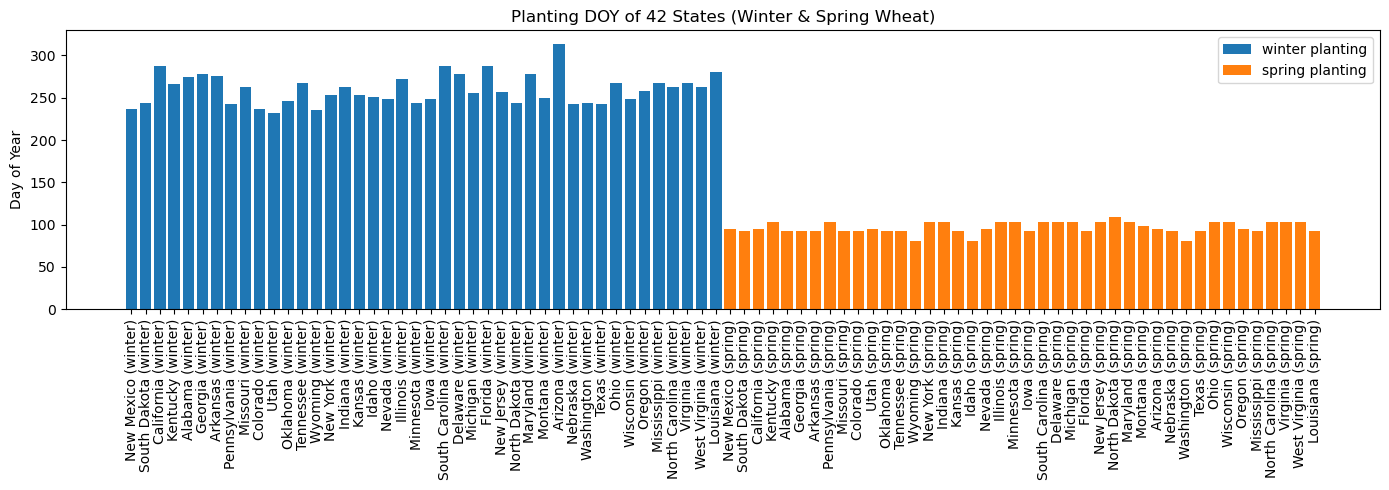

In [21]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt

os.makedirs("../data/crop_calendar_outputs", exist_ok=True)

# 修改为读取州级 geojson
gdf = gpd.read_file("us_states_42.geojson")

# NetCDF 文件路径
winter_nc = "../data/Wheat.Winter.crop.calendar.fill.nc"
spring_nc = "../data/Wheat.crop.calendar.fill.nc"

# 提取函数
def extract_dates(nc_file, season):
    ds = nc.Dataset(nc_file)

    lat = ds.variables['latitude'][:]
    lon = ds.variables['longitude'][:]
    planting_data = ds.variables['plant.start'][:, :]
    harvest_data = ds.variables['harvest.start'][:, :]

    if lat[0] < lat[-1]:
        lat = lat[::-1]
        planting_data = planting_data[::-1, :]
        harvest_data = harvest_data[::-1, :]

    records = []
    for _, row in gdf.iterrows():
        state = row['state'].title()
        geom = row['geometry']
        lon_c, lat_c = geom.centroid.x, geom.centroid.y

        lat_idx = (np.abs(lat - lat_c)).argmin()
        lon_idx = (np.abs(lon - lon_c)).argmin()

        try:
            planting = planting_data[lat_idx, lon_idx]
            harvesting = harvest_data[lat_idx, lon_idx]
        except:
            planting = np.nan
            harvesting = np.nan

        planting = planting if 1 <= planting <= 366 else np.nan
        harvesting = harvesting if 1 <= harvesting <= 366 else np.nan

        records.append({
            "state": state,
            "season": season,
            "planting_doy": planting,
            "harvest_doy": harvesting
        })

    return records

# 运行两季节提取
winter_records = extract_dates(winter_nc, "winter")
spring_records = extract_dates(spring_nc, "spring")
all_records = winter_records + spring_records

# 保存为 DataFrame
calendar_df = pd.DataFrame(all_records)
calendar_df.to_csv("../data/crop_calendar_outputs/wheat_calendar_42_states.csv", index=False)

# 可选：可视化
plt.figure(figsize=(14, 5))
for season in ["winter", "spring"]:
    sub = calendar_df[(calendar_df["season"] == season) & (~calendar_df["planting_doy"].isna())]
    plt.bar(sub['state'] + " (" + sub['season'] + ")", sub['planting_doy'], label=f"{season} planting")
plt.xticks(rotation=90)
plt.ylabel("Day of Year")
plt.title("Planting DOY of 42 States (Winter & Spring Wheat)")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
import requests
import pandas as pd
import time

API_KEY = "EDD77A29-6DA8-3B50-AFF6-E3A4C7BF8288"  # Replace with your API key
BASE_URL = "https://quickstats.nass.usda.gov/api/api_GET/"

# 42 selected wheat-producing states
states = [
    "Alabama", "Arizona", "Arkansas", "California", "Colorado", "Delaware", "Florida", "Georgia",
    "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maryland", "Michigan",
    "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Jersey", "New Mexico",
    "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
    "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Washington",
    "West Virginia", "Wisconsin", "Wyoming"
]

# Only census years: every 5 years
years = [2002, 2007, 2012, 2017, 2022]

# Function to query area data
def fetch_area(state, year, practice):
    params = {
        "key": API_KEY,
        "source_desc": "CENSUS",  # Only census years are supported
        "sector_desc": "CROPS",
        "group_desc": "FIELD CROPS",
        "commodity_desc": "WHEAT",
        "statisticcat_desc": "AREA HARVESTED",
        "unit_desc": "ACRES",
        "prodn_practice_desc": practice,  # "IRRIGATED" or "ALL PRODUCTION PRACTICES"
        "agg_level_desc": "STATE",
        "state_name": state,
        "year": str(year),
        "format": "JSON"
    }

    r = requests.get(BASE_URL, params=params)
    r.raise_for_status()
    data = r.json().get('data', [])
    if data:
        # Some values may contain commas, e.g. "1,234"
        try:
            return float(data[0]['Value'].replace(",", ""))
        except:
            return None
    return None

# Loop over all states and years
results = []
for state in states:
    for year in years:
        try:
            irr = fetch_area(state, year, "IRRIGATED")
            tot = fetch_area(state, year, "ALL PRODUCTION PRACTICES")
            ratio = irr / tot if irr and tot and tot > 0 else None
            results.append({
                "state": state,
                "year": year,
                "irr_acres": irr,
                "tot_acres": tot,
                "irr_frac": ratio
            })
            print(f"{state}-{year}: irrigated={irr}, total={tot}, fraction={ratio}")
            time.sleep(1)  # API rate limiting
        except Exception as e:
            print(f"Error fetching {state}-{year}: {e}")
            results.append({
                "state": state,
                "year": year,
                "irr_acres": None,
                "tot_acres": None,
                "irr_frac": None
            })

# Save results
df = pd.DataFrame(results)
df.to_csv("../data/wheat_irrigation_fraction_2002_2022.csv", index=False)
print("Saved: ../data/wheat_irrigation_fraction_2002_2022.csv")


Alabama-2002: irrigated=None, total=5072.0, fraction=None
Alabama-2007: irrigated=None, total=8179.0, fraction=None
Alabama-2012: irrigated=2300.0, total=33455.0, fraction=0.06874906590943058
Alabama-2017: irrigated=2648.0, total=34548.0, fraction=0.076646983906449
Alabama-2022: irrigated=4981.0, total=37368.0, fraction=0.13329586812245772
Arizona-2002: irrigated=45131.0, total=45131.0, fraction=1.0
Arizona-2007: irrigated=36324.0, total=36324.0, fraction=1.0
Arizona-2012: irrigated=50299.0, total=50299.0, fraction=1.0
Arizona-2017: irrigated=56408.0, total=56408.0, fraction=1.0
Arizona-2022: irrigated=36795.0, total=36795.0, fraction=1.0
Arkansas-2002: irrigated=13025.0, total=169578.0, fraction=0.07680831239901402
Arkansas-2007: irrigated=22400.0, total=185694.0, fraction=0.12062856096589011
Arkansas-2012: irrigated=12831.0, total=108822.0, fraction=0.11790814357390969
Arkansas-2017: irrigated=4513.0, total=31500.0, fraction=0.14326984126984127
Arkansas-2022: irrigated=3299.0, total=

不区分winter和spring版，用总产量建模

In [41]:
import os
import pandas as pd

# 输入路径配置
ndvi_dir = "../data/ndvi_states"
meteo_dir = "../data/gridmet_states"
soil_path = "../data/soil_states/soil_42_states.csv"
calendar_path = "../data/crop_calendar_outputs/wheat_calendar_42_states.csv"
irr_path = "../data/wheat_irrigation_fraction_2002_2022.csv"
yield_path = "../data/state_yield_filled_2000_2024.csv"

# 读取数据
soil_df = pd.read_csv(soil_path)
calendar_df = pd.read_csv(calendar_path)
irr_df = pd.read_csv(irr_path)
yield_df = pd.read_csv(yield_path)

# 标准化名称
soil_df["state"] = soil_df["state"].str.title()
calendar_df["state"] = calendar_df["state"].str.title()
irr_df["state"] = irr_df["state"].str.title()
yield_df["state"] = yield_df["state"].str.title()

def load_monthly_features(state, year):
    try:
        ndvi_df = pd.read_csv(f"{ndvi_dir}/{state}.csv")
        meteo_df = pd.read_csv(f"{meteo_dir}/{state}.csv")
    except FileNotFoundError:
        return None

    ndvi_df = ndvi_df[ndvi_df["year"] == year]
    meteo_df = meteo_df[meteo_df["year"] == year]

    if len(ndvi_df) != 12 or len(meteo_df) != 12:
        return None

    ndvi_df["month"] = ndvi_df["month"].astype(int)
    meteo_df["month"] = meteo_df["month"].astype(int)

    ndvi_pivot = ndvi_df.pivot(index='year', columns='month', values='ndvi')
    ndvi_pivot.columns = [f"ndvi_{m:02d}" for m in ndvi_pivot.columns]

    temp_pivot = meteo_df.pivot(index='year', columns='month', values='tmmx_c')
    temp_pivot.columns = [f"tmax_{m:02d}" for m in temp_pivot.columns]

    prcp_pivot = meteo_df.pivot(index='year', columns='month', values='precip_mm')
    prcp_pivot.columns = [f"precip_{m:02d}" for m in prcp_pivot.columns]

    return pd.concat([ndvi_pivot, temp_pivot, prcp_pivot], axis=1).reset_index(drop=True)

# 构建整合主表
records = []

for _, row in yield_df.iterrows():
    state, year, yld = row["state"], row["year"], row["yield"]
    base = {"state": state, "year": year, "yield": yld}

    # 加载时序 NDVI + 气象特征
    features = load_monthly_features(state, year)
    if features is None:
        continue
    base.update(features.iloc[0].to_dict())

    # 静态土壤数据
    soil = soil_df[soil_df["state"] == state]
    if not soil.empty:
        base.update(soil.iloc[0].drop("state").to_dict())

    # 灌溉比例
    irr = irr_df[(irr_df["state"] == state) & (irr_df["year"] == year)]
    base["irr_frac"] = irr["irr_frac"].values[0] if not irr.empty else None

    # 播种与收获日期，优先使用 winter 季节
    cal = calendar_df[calendar_df["state"] == state]
    if not cal.empty:
        if "winter" in cal["season"].values:
            row_cal = cal[cal["season"] == "winter"].iloc[0]
        else:
            row_cal = cal.iloc[0]
        base["planting_doy"] = row_cal["planting_doy"]
        base["harvest_doy"] = row_cal["harvest_doy"]

    records.append(base)

# 构建最终 DataFrame
full_df = pd.DataFrame(records)

# 保存结果
out_path = "../data/lstm_input_states.csv"
full_df.to_csv(out_path, index=False)
print(f"Saved merged file: {out_path} ({len(full_df)} samples)")


Saved merged file: ../data/lstm_input_states.csv (884 samples)


In [42]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取用户上传的整合版数据
df = pd.read_csv("../data/lstm_input_states.csv")

# ===== Step 1: 灌溉数据处理（irr_frac 填补 + irr_flag 分类） =====
df['irr_frac_filled'] = None
df['irr_flag'] = 0

for state in df['state'].unique():
    mask = df['state'] == state
    irr_data = df.loc[mask, 'irr_frac']
    non_na = irr_data.dropna()

    if non_na.empty or non_na.max() < 0.05:
        df.loc[mask, 'irr_frac_filled'] = 0.0
        df.loc[mask, 'irr_flag'] = 0
    else:
        mean_irr = non_na.mean()
        df.loc[mask, 'irr_frac_filled'] = irr_data.fillna(mean_irr)
        df.loc[mask, 'irr_flag'] = (df.loc[mask, 'irr_frac_filled'] >= 0.5).astype(int)

# ===== Step 2: NDVI 插值处理（横向插值） =====
ndvi_cols = [col for col in df.columns if col.startswith("ndvi_")]
df[ndvi_cols] = df[ndvi_cols].interpolate(axis=1, limit_direction="both")

# ===== Step 3: 数值特征归一化 =====
weather_cols = [col for col in df.columns if col.startswith(("tmax", "precip"))]
soil_cols = ["ph", "ocd", "clay", "sand", "silt", "bd"]

# 合并 NDVI + 气象 + 土壤列
scale_cols = ndvi_cols + weather_cols + soil_cols

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[scale_cols])
df[scale_cols] = scaled_values

# ===== Step 4: 删除 irr_frac，仅保留 irr_flag =====
df = df.drop(columns=["irr_frac", "irr_frac_filled"])
# ========== Step 5: 保存 ==========
output_path = "../data/lstm_input_states_cleaned.csv"
df.to_csv(output_path, index=False)
print(f" Cleaned dataset saved to: {output_path}")

 Cleaned dataset saved to: ../data/lstm_input_states_cleaned.csv


区分winter和spring

In [37]:
import os
import pandas as pd

# 输入路径配置
ndvi_dir = "../data/ndvi_states"
meteo_dir = "../data/gridmet_states"
soil_path = "../data/soil_states/soil_42_states.csv"
calendar_path = "../data/crop_calendar_outputs/wheat_calendar_42_states.csv"
irr_path = "../data/wheat_irrigation_fraction_2002_2022.csv"

# 季节对应的 yield 数据
yield_paths = {
    "spring": "../data/spring_yield_filled_2000_2024.csv",
    "winter": "../data/winter_yield_filled_2000_2024.csv"
}

# 读取静态数据
soil_df = pd.read_csv(soil_path)
calendar_df = pd.read_csv(calendar_path)
irr_df = pd.read_csv(irr_path)

# 标准化名称
soil_df["state"] = soil_df["state"].str.title()
calendar_df["state"] = calendar_df["state"].str.title()
irr_df["state"] = irr_df["state"].str.title()

def load_monthly_features(state, year):
    try:
        ndvi_df = pd.read_csv(f"{ndvi_dir}/{state}.csv")
        meteo_df = pd.read_csv(f"{meteo_dir}/{state}.csv")
    except FileNotFoundError:
        return None
    
    ndvi_df = ndvi_df[ndvi_df["year"] == year]
    meteo_df = meteo_df[meteo_df["year"] == year]

    if len(ndvi_df) != 12 or len(meteo_df) != 12:
        return None

    ndvi_df["month"] = ndvi_df["month"].astype(int)
    meteo_df["month"] = meteo_df["month"].astype(int)

    ndvi_pivot = ndvi_df.pivot(index='year', columns='month', values='ndvi')
    ndvi_pivot.columns = [f"ndvi_{m:02d}" for m in ndvi_pivot.columns]

    temp_pivot = meteo_df.pivot(index='year', columns='month', values='tmmx_c')
    temp_pivot.columns = [f"tmax_{m:02d}" for m in temp_pivot.columns]

    prcp_pivot = meteo_df.pivot(index='year', columns='month', values='precip_mm')
    prcp_pivot.columns = [f"precip_{m:02d}" for m in prcp_pivot.columns]

    return pd.concat([ndvi_pivot, temp_pivot, prcp_pivot], axis=1).reset_index(drop=True)

def build_master(season):
    df = pd.read_csv(yield_paths[season])
    df["state"] = df["state"].str.title()
    records = []

    for _, row in df.iterrows():
        state, year, yld = row["state"], row["year"], row["yield_bu_acre"]
        base = {"state": state, "year": year, "yield_bu_acre": yld}

        features = load_monthly_features(state, year)
        if features is None:
            continue
        base.update(features.iloc[0].to_dict())

        soil = soil_df[soil_df["state"] == state]
        if not soil.empty:
            base.update(soil.iloc[0].drop("state").to_dict())

        irr = irr_df[(irr_df["state"] == state) & (irr_df["year"] == year)]
        base["irr_frac"] = irr["irr_frac"].values[0] if not irr.empty else None

        cal = calendar_df[(calendar_df["state"] == state) & (calendar_df["season"] == season)]
        base["planting_doy"] = cal["planting_doy"].values[0] if not cal.empty else None
        base["harvest_doy"] = cal["harvest_doy"].values[0] if not cal.empty else None

        records.append(base)

    final_df = pd.DataFrame(records)
    out_path = f"../data/lstm_input_{season}.csv"
    final_df.to_csv(out_path, index=False)
    print(f" Saved: {out_path}  ({len(final_df)} samples)")

# 分别生成两个主表
build_master("spring")
build_master("winter")


 Saved: ../data/lstm_input_spring.csv  (240 samples)
 Saved: ../data/lstm_input_winter.csv  (816 samples)


In [38]:
import pandas as pd

# 重新加载文件（因为环境已重置）
spring_path = "../data/lstm_input_spring.csv"
winter_path = "../data/lstm_input_winter.csv"

spring_df = pd.read_csv(spring_path)
winter_df = pd.read_csv(winter_path)

def fill_irrigation_flags(df):
    result_df = df.copy()
    states = result_df['state'].unique()

    # 初始化新列
    result_df['irr_frac_filled'] = None
    result_df['irr_flag'] = 0

    for state in states:
        state_mask = result_df['state'] == state
        state_data = result_df.loc[state_mask, 'irr_frac']
        non_na = state_data.dropna()

        if non_na.empty or non_na.max() < 0.05:
            # 类别1：完全无灌溉
            result_df.loc[state_mask, 'irr_frac_filled'] = 0.0
            result_df.loc[state_mask, 'irr_flag'] = 0
        else:
            # 类别2：部分灌溉，使用州内均值填补
            mean_irr = non_na.mean()
            result_df.loc[state_mask, 'irr_frac_filled'] = state_data.fillna(mean_irr)
            result_df.loc[state_mask, 'irr_flag'] = (result_df.loc[state_mask, 'irr_frac_filled'] >= 0.5).astype(int)

    return result_df

# 应用填补策略
spring_df_filled = fill_irrigation_flags(spring_df)
winter_df_filled = fill_irrigation_flags(winter_df)

# 保存结果
spring_out = "../data/lstm_input_spring_with_irrigation_flags.csv"
winter_out = "../data/lstm_input_winter_with_irrigation_flags.csv"

spring_df_filled.to_csv(spring_out, index=False)
winter_df_filled.to_csv(winter_out, index=False)

spring_out, winter_out

('../data/lstm_input_spring_with_irrigation_flags.csv',
 '../data/lstm_input_winter_with_irrigation_flags.csv')

In [39]:
# Re-import necessary libraries after kernel reset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load both datasets again
spring_df = pd.read_csv("../data/lstm_input_spring_with_irrigation_flags.csv")
winter_df = pd.read_csv("../data/lstm_input_winter_with_irrigation_flags.csv")

# Define column groups
ndvi_cols = [col for col in spring_df.columns if col.startswith("ndvi_")]
weather_cols = [col for col in spring_df.columns if any(col.startswith(prefix) for prefix in ["tmmx", "tmmn", "prcp", "srad"])]
soil_cols = ["ph", "ocd", "clay", "sand", "silt", "bd"]

# Interpolate missing NDVI values
spring_df[ndvi_cols] = spring_df[ndvi_cols].interpolate(axis=1, limit_direction="both")
winter_df[ndvi_cols] = winter_df[ndvi_cols].interpolate(axis=1, limit_direction="both")

# Combine datasets to fit one common scaler
combined = pd.concat([
    spring_df[ndvi_cols + weather_cols + soil_cols],
    winter_df[ndvi_cols + weather_cols + soil_cols]
], axis=0)

# Fit MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(combined)

# Apply transformation
spring_scaled = scaler.transform(spring_df[ndvi_cols + weather_cols + soil_cols])
winter_scaled = scaler.transform(winter_df[ndvi_cols + weather_cols + soil_cols])

# Assign scaled values back
spring_df[ndvi_cols + weather_cols + soil_cols] = spring_scaled
winter_df[ndvi_cols + weather_cols + soil_cols] = winter_scaled

# Save the processed files
spring_output_path = "../data/lstm_input_spring_final.csv"
winter_output_path = "../data/lstm_input_winter_final.csv"
spring_df.to_csv(spring_output_path, index=False)
winter_df.to_csv(winter_output_path, index=False)

spring_output_path, winter_output_path


('../data/lstm_input_spring_final.csv', '../data/lstm_input_winter_final.csv')

In [40]:
import pandas as pd

# Load the final datasets
spring_path = "../data/lstm_input_spring_final.csv"
winter_path = "../data/lstm_input_winter_final.csv"

spring_df = pd.read_csv(spring_path)
winter_df = pd.read_csv(winter_path)

# Drop irr_frac but retain irr_flag
spring_cleaned = spring_df.drop(columns=["irr_frac"])
winter_cleaned = winter_df.drop(columns=["irr_frac"])

# Save the cleaned datasets
spring_cleaned_path = "../data/lstm_input_spring_final_flagonly.csv"
winter_cleaned_path = "../data/lstm_input_winter_final_flagonly.csv"

spring_cleaned.to_csv(spring_cleaned_path, index=False)
winter_cleaned.to_csv(winter_cleaned_path, index=False)

spring_cleaned_path, winter_cleaned_path


('../data/lstm_input_spring_final_flagonly.csv',
 '../data/lstm_input_winter_final_flagonly.csv')